# ML Final Report
### Ben Richardson and Kendra Noneman

#### Link for documentation: https://huggingface.co/docs/transformers/model_doc/clip

In [1]:
from PIL import Image
import requests
import torch
import numpy as np
from gtts import gTTS
import matplotlib.pyplot as plt
from playsound import playsound
from audio2numpy import open_audio
import ffmpeg
import numpy as np
import librosa
from scipy.signal import butter,filtfilt


from transformers import CLIPProcessor, CLIPModel

### Acoustic Model:

##### Hubert: 
"Forces the model to learn a combined acoustic and language model over the continuous inputs":
https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/hubert#overview



### Multimodal Model:

##### CLIPModel:
Model configuration class with all the parameters of the model. Initializing with a config file does not load the weights associated with the model, only the configuration.
 
##### from_pretrained:
Changes the weights (including mapping hidden states to vocabulary, pruning and initializing weights, tying the weights between the input embeddings and the output embeddings, etc...)
https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

Options for CLIP pre-trained openai models (4 of them):
https://huggingface.co/openai

##### CLIPProcessor:
Constructs a CLIP processor which wraps a CLIP feature extractor and a CLIP tokenizer into a single processor

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

In [4]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
print(inputs["input_ids"])
print(inputs["input_ids"].shape)


tensor([[49406,   320,  1125,   539,   320,  2368, 49407],
        [49406,   320,  1125,   539,   320,  1929, 49407]])
torch.Size([2, 7])


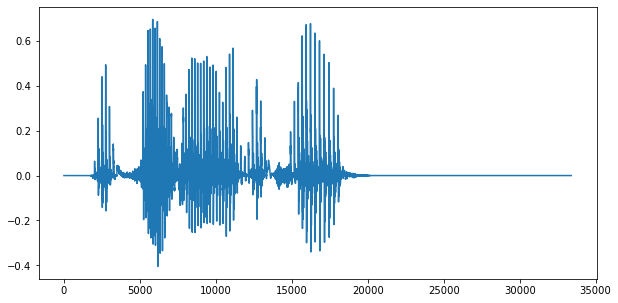

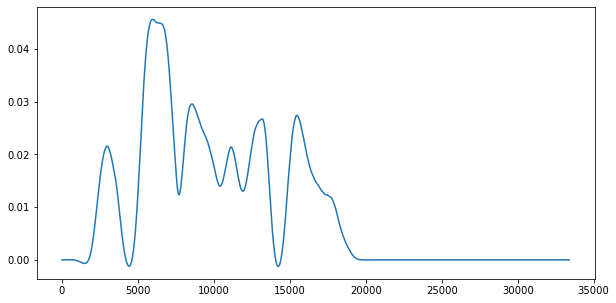

In [5]:
## Text to Speech, determine pitch contour
text_to_convert = "a photo of a cat"
language = "en"
import pyttsx3  
s = pyttsx3.init()   
s.say(text_to_convert)  
s.runAndWait()
s.save_to_file(text_to_convert, 'speech.mp3')
signal, fs = open_audio('speech.mp3')
# SIGNAL
plt.figure(figsize = (10,5))
plt.plot(signal)
# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(signal, 15, fs, 2)
plt.figure(figsize = (10,5))
plt.plot(signal_lpf)


In [6]:
# Find the n words with largest auditory cue, and then set the attention mask to 1 only for those words

inputs["attention_mask"] = torch.Tensor([[1,1,1,1,1,1,1],[1,1,1,1,1,1,1]])
#torch.Tensor([np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist(),np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist()])
print(np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist())


[1.0, 0.8333333333333334, 0.6666666666666667, 0.5, 0.33333333333333337, 0.16666666666666674, 0.0]


In [7]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [8]:
print(probs)

tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward0>)
